In [1]:
import numpy as np
from scipy import linalg as la
import numpy as np
import matplotlib
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
def compute_view_matrix(position, target, up):
    '''
    Inputs: 
        position : 3D coordinates of the camera center in world coordinates
        target : 3D coordinates of the camera target in world coordinates
        up : vector specifying the up direction of the camera. should be orthogonal to (target-position)
    Outputs:
        P : 3 x 4 camera extrinsic matrix, a concatenation of rotation matrix and translation matrix
    '''
    L = target - position
    L = L / np.linalg.norm(L)
    s = np.cross(L, up)
    s = s / np.linalg.norm(s)
    u_prime = np.cross(s,L)
    R = np.r_[s,u_prime,-L].reshape((3,3))
    T = -R @ position
    P = np.c_[R,T]
    return P

In [3]:
def project(position,target,up,X):
    '''
    Given camera extrinsic details, and 3D points X, 
    return the homogenous coordinates of Y,
    which are projected into the camera plane.
    See compute_view_matrix() details
    '''
    P = compute_view_matrix(position,target,up)
    if len(X.shape) > 1:
        _,n = X.shape
        Y = P @ np.r_[X,np.ones((1,n))]
        Y /= Y[2,:]
        return Y
    else:
        Y = P @ np.r_[X,1]
        Y /= Y[2]
        return Y

In [4]:
def fundamental_matrix(Y,Yp):
    '''
    Inputs:
        Y : all keypoints from camera 1 in homogenous coordinates in a (3 x n_kp) matrix
        Yp : same from camera 2
    Outputs:
        F : fundamental matrix between stereo cameras
    Desc:
        Solved using the 7-point algorithm. It is assumed that matching keypoints are aligned
        by column. At least 7 matches required. 
    TODO: 
        Implement normalized version. Camera intrinsics needed?
    '''
    n = Y.shape[1]
    X = np.zeros((n,9))
    for i in range(n):
        X[i] = np.outer(Yp[:,i],Y[:,i]).flatten()
        
    U,S,Vh = la.svd(X)
    F = Vh[len(Vh)-1].reshape((3,3))
    U,S,Vh = la.svd(F)
    S[2] = 0
    F = U @ np.diag(S) @ Vh
    return F

In [5]:
# n Target points 
n = 10
X = np.random.uniform(-3,3,(3,n))

cam1_pos = np.array([-5,-5,0])
cam1_tgt = np.array([0,0,0])
cam1_up = np.array([0,0,1])
cam1_Y = project(cam1_pos, cam1_tgt, cam1_up, X)

cam2_pos = np.array([-5,5,1])
cam2_tgt = np.array([0,0,0])
cam2_up = np.array([0,-1,5])
cam2_Y = project(cam2_pos, cam2_tgt, cam2_up, X)

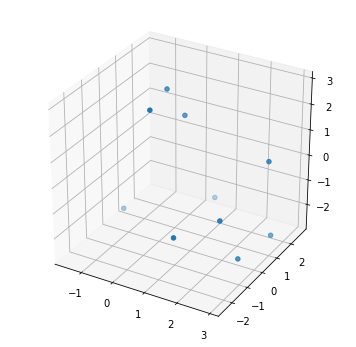

In [6]:
fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X[0,:],X[1,:],X[2,:])
plt.show()

<Figure size 432x288 with 0 Axes>

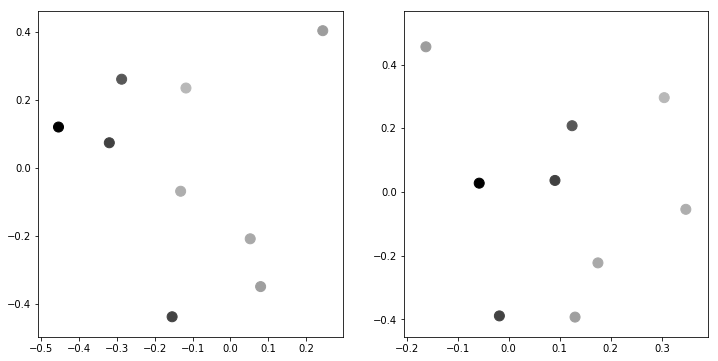

In [7]:
plt.gray()
fig = plt.figure(figsize=(12,6))
ax = fig.add_subplot(121)
ax.scatter(cam1_Y[0,:],cam1_Y[1,:],c=X[1,:],s=100)
ax = fig.add_subplot(122)
ax.scatter(cam2_Y[0,:],cam2_Y[1,:],c=X[1,:],s=100)
plt.show()

In [8]:
F0 = fundamental_matrix(cam1_Y, cam2_Y)

In [69]:
def rigid_normalize(x,e):
    # Transform x to be at the origin and compute L
    L = np.eye(3)
    L[:2,2] = -x[:2]
    # Find rotation theta by using the epipolar line
    theta = np.arctan( - (e[1] - e[2] * x[1]) / (e[0] - e[2] * x[0]) )
    R = np.array( [ [np.cos(theta), -np.sin(theta),0],[np.sin(theta),np.cos(theta),0],[0,0,1] ] )
    T = R @ L
    # Enforce that RLe[0] = 1
    T /= (T @ e)[0]
    return T
    

In [70]:
def fundamental_normalize(x,xp,e,ep,F0):
    T = rigid_normalize(x,e)
    Tp = rigid_normalize(xp,ep)
    F = Tp @ F0 @ la.pinv(T)
    return T,Tp,F
    

In [84]:
def harley_sturm_single_point(x,xp,e,ep,F0):
    T,Tp,F = fundamental_normalize(x,xp,e,ep,F0)
    
    a = F[1,1]
    b = F[1,2]
    c = F[2,1]
    d = F[2,2]
    f = -F[2,0] / d
    fp = -F[0,2] / d
    
    alpha = a**2 + fp**2 * c**2
    beta = 2*a*b + 2*c*d*fp**2
    gamma = b**2 + d**2 * fp**2
    
    # coefficients are co0 through co6
    co6 = a*c*f**4
    co5 = a*b*f**4 + b*c*f**4 + alpha
    co4 = b*d*f**4 + 2*a*c*f**2 + 2*alpha*beta
    co3 = 2*a*d*f**2 + 2*b*c*f**2 + 2*alpha*gamma + beta**2
    co2 = a*c + 2*b*d*f**2 + 2*beta*gamma
    co1 = b*c + a*d + gamma**2
    co0 = b*d
    
    r = np.roots(np.array([co6,co5,co4,co3,co2,co1,co0]))
    print(r)
    s = lambda t : t**2 / ( 1 + (t*f)**2 ) + ( c*t + d )**2 / ( (a*t + b)**2 + fp**2 * (c*t + d)**2 )
    print(s(r[2]),s(r[5]))
    return(s(r[5]))

In [12]:
e = project(cam1_pos, cam1_tgt, cam1_up, cam2_pos)
ep = project(cam2_pos, cam2_tgt, cam2_up, cam1_pos)
print(e, ep)

[ 1.         -0.14142136  1.        ] [-0.98058068 -0.13730876  1.        ]


In [42]:
u = cam1_Y[:,0]
up = cam2_Y[:,0]
T,Tp,F = fundamental_normalize(u,up,e,ep,F0)
print(F)

[[ 6.29750955e-02  2.33792126e-01 -1.19121958e-01]
 [ 4.19357598e-01  2.97841720e-16 -3.55367639e-01]
 [-1.16902063e-01  3.52215378e-01  7.24619896e-17]]


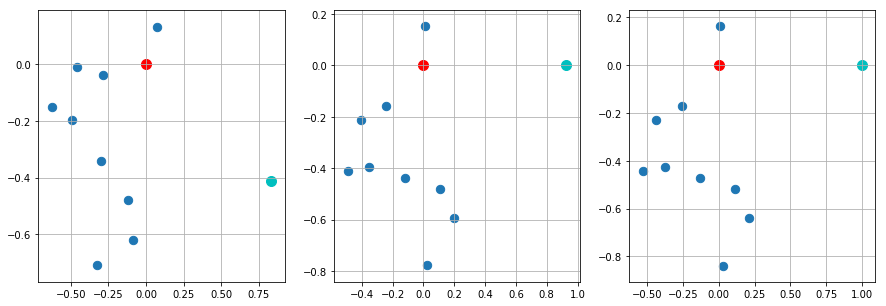

In [62]:
L,R,T = rigid_normalize(u,e)
YL = L @ cam1_Y
eL = L @ e
fig = plt.figure(figsize=(15,5))
ax = fig.add_subplot(131)
ax.scatter(YL[0,1:],YL[1,1:],s=70)
ax.scatter(YL[0,0],YL[1,0],c='r',s=100)
ax.scatter(eL[0],eL[1],c='c',s=100)
ax.grid(True)
YRL = R @ YL
eRL = R @ eL
ax = fig.add_subplot(132)
ax.scatter(YRL[0,1:],YRL[1,1:],s=70)
ax.scatter(YRL[0,0],YRL[1,0],c='r',s=100)
ax.scatter(eRL[0],eRL[1],c='c',s=100)
ax.grid(True)
YT = T @ cam1_Y
eT = T @ e
ax = fig.add_subplot(133)
ax.scatter(YT[0,1:],YT[1,1:],s=70)
ax.scatter(YT[0,0],YT[1,0],c='r',s=100)
ax.scatter(eT[0],eT[1],c='c',s=100)
ax.grid(True)

In [68]:
Lp,Rp,Tp = rigid_normalize(up,ep)
print(Tp @ F0 @ la.pinv(T))

[[ 0.05095634  0.16845397 -0.04725283]
 [ 0.35107651 -0.09722053 -0.32556023]
 [-0.10052668  0.30287782  0.09322039]]


In [66]:
F = Tp @ F0 @ la.pinv(T)
a = F[1,1]
b = F[1,2]
c = F[2,1]
d = F[2,2]
f = -F[2,0] / d
fp = -F[0,2] / d
print(f*fp*d)
print(-fp*c)
print(-fp*d)

0.050956338532391544
-0.153526854952694
-0.04725282636208791


In [85]:
t = harley_sturm_single_point(u,up,e,ep,F0)
print(t)

[ 0.25367772+1.65307787j  0.25367772-1.65307787j -1.73270339+0.j
  0.05674766+0.68521259j  0.05674766-0.68521259j -0.33265669+0.j        ]
(3.2361352303416977-0j) (0.09870363947881092-0j)
(0.09870363947881092-0j)
